In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


character(0)

# VAR

<a id="2"></a> <br>
##  Importacion de librerías requeridas

In [2]:
options(warn = - 1) 
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
options(warn = - 1) 

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is n

<a id="3"></a> <br>
##  Importacion de datos

In [3]:
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")

#--------- Funcisn para bajar precios y generar rendimientos:
rend<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interis:
  datos<-datos[,4]
  ##--------Rendimientos simples:
  #rend<-periodReturn(datos, period = "daily", type='arithmetic')                         
  #------ --Para hacer dtos accesibles  GLobal ENv:
  assign(simbolo, datos, envir = .GlobalEnv)
}

#### Llamar la funcion para cada activo particular:

In [4]:
rend("RYLD")
rend("TSLA")
rend("TM")
rend("GM")

<a id="4"></a> <br>
## Visualización de los datos

In [5]:
## Juntamos los datos, renombramos las columnas y las visualizamos:
prices<-merge.xts(`RYLD`, `TSLA`, `TM`, `GM`,join='inner')%>% na.omit()
dim(prices)
colnames(prices)<-c("RYLD", "TSLA", "TM", "GM")
dygraph(prices, main = "RYLD", "TSLA", "TM") %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))


[1] 933   4

HTML widgets cannot be represented in plain text (need html)

<a id="4"></a> <br>
## Division Train - Test

Division los datos en 5% de test y 95% de entrenamiento 

In [6]:
#Partimos serie para train & test
h <- round(nrow(prices)*0.05, digits = 0 )
h
prices_train <- prices[1:(nrow(prices) - h), ]
prices_test<- prices[(nrow(prices) - h + 1):nrow(prices), ]

[1] 47

In [7]:
nrow(prices)
nrow(prices_train)
nrow(prices_test)

[1] 933

[1] 886

[1] 47

Para este ejercicio primero se realizó el modelo para las series sin diferenciar y luego se hizo el analisis con el portafolio diferenciado

<a id="5"></a> <br>
## Prueba cointegración:

In [8]:
library(urca)
library(vars)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: strucchange

Loading required package: sandwich


Attaching package: ‘strucchange’


The following object is masked from ‘package:stringr’:

    boundary


Loading required package: lmtest



<a id="6"></a> <br>
### Nivel K selection

In [9]:
nivelk=VARselect(prices_train, lag.max = 7, type = "trend") #constant means there is an intercept included in each equation in the model. "trend" means there is a linear time trend included. "both" means that there is a constant in their relation and trend included. none means neither of them is included.
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3

<a id="7"></a> <br>
### Johansen Test

In [10]:
johatest=ca.jo(prices_train, type = "trace", K=3, ecdet ="trend", spec = "longrun") #K is the number of lags to use in the vector autoregressive model and is set this to the minimum, K=2.
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend in cointegration 

Eigenvalues (lambda):
[1]  2.529741e-02  1.357218e-02  5.897507e-03  2.248613e-03 -2.881042e-18

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  1.99 10.49 12.25 16.26
r <= 2 |  7.21 22.76 25.32 30.45
r <= 1 | 19.28 39.06 42.44 48.45
r = 0  | 41.90 59.14 62.99 70.05

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              RYLD.l3     TSLA.l3        TM.l3      GM.l3    trend.l3
RYLD.l3   1.000000000  1.00000000  1.000000000  1.0000000  1.00000000
TSLA.l3   0.044516921  0.03908185 -0.016139393 -0.3212458 -0.07972160
TM.l3    -0.154225497  0.30333694 -0.019835997 -0.5182983 -0.24243506
GM.l3    -0.189938878 -0.84924016 -0.048110677 -0.9450700  0.18981925
trend.l3 -0.003581061 -0.01320774  0.009155525  0.1194600  0.06820413

Weights W:
(This is the loading matrix)

A traves de la prueba se determina que las series no estan cointegradas ya que el valor de test es siempre menor a todos los estadisticos de prueba

<a id="4"></a> <br>
# Modelos:

Se prerparan los datos para poder utilizar las librerias VAR y MTS, se colocan los formatos adecuados, es importante resaltar que esta primera parte no se han diferenciado las series

In [11]:
ryld=ts(prices_train$RYLD, start= c(2019,01,01), frequency = 365)
tsla=ts(prices_train$TSLA, start= c(2019,01,01), frequency = 365)
tm= ts(prices_train$TM, start= c(2019,01,01), frequency = 365)
gm= ts(prices_train$GM, start= c(2019,01,01), frequency = 365)

In [12]:
dataVAR2=ts.intersect(ryld, tsla, tm, gm) %>% na.omit()
head(dataVAR2)

ryld,tsla,tm,gm
24.995,17.51667,124.16,39.50
25.157,17.59333,124.94,39.83
25.189,17.24400,122.88,39.72
25.130,16.50867,123.19,39.11
25.225,15.67600,123.62,39.68
25.250,16.09800,123.81,40.01


<a id="9"></a> <br>
## VAR

In [13]:
m1 <- vars::VAR(y=dataVAR2, lag.max = 7)
summary(m1)


VAR Estimation Results:
Endogenous variables: ryld, tsla, tm, gm 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6043.153 
Roots of the characteristic polynomial:
0.9974 0.9882 0.9786 0.9786 0.5739 0.4346 0.2687 0.2687 0.2396 0.2396 0.1713 0.1456
Call:
vars::VAR(y = dataVAR2, lag.max = 7)


Estimation results for equation ryld: 
ryld = ryld.l1 + tsla.l1 + tm.l1 + gm.l1 + ryld.l2 + tsla.l2 + tm.l2 + gm.l2 + ryld.l3 + tsla.l3 + tm.l3 + gm.l3 + const 

          Estimate Std. Error t value Pr(>|t|)    
ryld.l1  0.8516477  0.0429091  19.848  < 2e-16 ***
tsla.l1  0.0003953  0.0011973   0.330   0.7414    
tm.l1   -0.0022382  0.0046864  -0.478   0.6331    
gm.l1    0.0167489  0.0105272   1.591   0.1120    
ryld.l2  0.4233599  0.0556524   7.607 7.27e-14 ***
tsla.l2 -0.0027116  0.0016366  -1.657   0.0979 .  
tm.l2    0.0015589  0.0066827   0.233   0.8156    
gm.l2   -0.0353304  0.0143403  -2.464   0.0139 *  
ryld.l3 -0.2897341  0.0428613  -6.760 2.53e-11 ***
tsla.l3  0.0020

<a id="9"></a> <br>
## MTS

Se utiliza esta libreria para poder realizar la descomposición singular a la matriz de coeficientes regresivos y observar que no haya valores caracteríticos mayores a la unidad.

In [14]:
#Para ver si es correcto este enfoque, de desarrollar el VAR en portafolio no diferenciado, podemos aplicar la descomposición singular a la matriz de coeficientes regresivos y observar que no haya valores caracteríticos mayores a la unidad.
library(MTS)
m2=VARorder(dataVAR2)


Attaching package: ‘MTS’


The following object is masked from ‘package:vars’:

    VAR




selected order: aic =  3 
selected order: bic =  1 
selected order: hq =  3 
Summary table:  
       p     AIC     BIC      HQ       M(p) p-value
 [1,]  0 19.1002 19.1002 19.1002     0.0000  0.0000
 [2,]  1  2.5494  2.6358  2.5824 14389.1242  0.0000
 [3,]  2  2.5316  2.7044  2.5977    46.5819  0.0001
 [4,]  3  2.4832  2.7425  2.5823    72.6151  0.0000
 [5,]  4  2.5115  2.8572  2.6437     6.7076  0.9785
 [6,]  5  2.5226  2.9548  2.6878    21.2669  0.1685
 [7,]  6  2.5367  3.0554  2.7350    18.6596  0.2867
 [8,]  7  2.5528  3.1579  2.7841    16.8925  0.3926
 [9,]  8  2.5443  3.2358  2.8086    37.4936  0.0018
[10,]  9  2.5524  3.3304  2.8499    23.3347  0.1051
[11,] 10  2.5440  3.4085  2.8745    37.0236  0.0021
[12,] 11  2.5562  3.5071  2.9197    19.7991  0.2294
[13,] 12  2.5589  3.5962  2.9554    27.5603  0.0357
[14,] 13  2.5773  3.7010  3.0069    14.5011  0.5614


Observamos que el parametro de regresiones es 3

In [15]:
#Vemos que el orden regresivo es similar, con l=3. Procedemos con el modelo VAR mediante librería MTS
m2_mts=MTS::VAR(dataVAR2, 3)

Constant term: 
Estimates:  0.2608444 0.03875493 2.140639 0.6457194 
Std.Error:  0.1194969 3.693215 1.041164 0.4939372 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]     [,2]     [,3]    [,4]
[1,]  0.8516 0.000395 -0.00224  0.0167
[2,]  1.1091 0.951521 -0.00861 -0.2976
[3,] -1.0731 0.015418  0.99812  0.0873
[4,] -0.0154 0.010816 -0.01228  0.9725
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00469 0.0105
[2,] 1.3262 0.03700 0.14484 0.3254
[3,] 0.3739 0.01043 0.04083 0.0917
[4,] 0.1774 0.00495 0.01937 0.0435
AR( 2 )-matrix 
      [,1]     [,2]      [,3]     [,4]
[1,] 0.423 -0.00271  0.001559 -0.03533
[2,] 1.135  0.03052 -0.003307  0.28620
[3,] 1.311 -0.02049  0.000282  0.03689
[4,] 0.496 -0.01826 -0.022626 -0.00889
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0557 0.00164 0.00668 0.0143
[2,] 1.7200 0.05058 0.20654 0.4432
[3,] 0.4849 0.01426 0.05823 0.1249
[4,] 0.2300 0.00676 0.02762 0.0593
AR( 3 )-matrix 
       [,1]    [,2]      [,3]    [,4]

In [16]:
#Procedemos con el análisis de estacionariedad en la matriz regresiva
str(m2_mts)

List of 13
 $ data     : Time-Series [1:886, 1:4] from 2019 to 2021: 25 25.2 25.2 25.1 25.2 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "ryld" "tsla" "tm" "gm"
 $ cnst     : logi TRUE
 $ order    : num 3
 $ coef     : num [1:13, 1:4] 0.260844 0.851648 0.000395 -0.002238 0.016749 ...
 $ aic      : num 2.44
 $ bic      : num 2.7
 $ hq       : num 2.54
 $ residuals: num [1:883, 1:4] -0.0921 0.0883 0.0385 -0.0524 -0.0703 ...
 $ secoef   : num [1:13, 1:4] 0.1195 0.04291 0.0012 0.00469 0.01053 ...
 $ Sigma    : num [1:4, 1:4] 0.0682 0.7981 0.2907 0.1611 0.7981 ...
 $ Phi      : num [1:4, 1:12] 0.851648 1.109137 -1.073107 -0.015358 0.000395 ...
 $ Ph0      : num [1:4] 0.2608 0.0388 2.1406 0.6457
 $ fixed    : NULL


In [17]:
phi1=m2_mts$Phi[,c(1,2,3,4)]
phi2=m2_mts$Phi[,c(5,6,7,8)]
phi3=m2_mts$Phi[,c(9,10,11,12)]
phi1
phi2
phi3

0.85164765,0.000395267,-0.002238194,0.01674888
1.10913747,0.951520992,-0.008607675,-0.29761027
-1.07310736,0.015418408,0.998116874,0.08734625
-0.01535757,0.010816349,-0.012279599,0.97248465


0.4233599,-0.002711628,0.0015589236,-0.035330422
1.1347858,0.030523084,-0.0033066969,0.286197271
1.3113626,-0.020490153,0.0002818211,0.036894425
0.4962547,-0.018263847,-0.0226260531,-0.008893495


-0.2897341,0.002094185,0.0004838902,0.02194639
-2.4065012,0.008652822,0.0435505308,0.03051971
-0.2527456,0.005925546,-0.0201592783,-0.09241788
-0.4413252,0.009407704,0.0239756460,0.03033876


In [18]:
eigen(phi1)
eigen(phi2)
eigen(phi3)

eigen() decomposition
$values
[1] 1.019258+0.00000000i 0.948173+0.04702782i 0.948173-0.04702782i
[4] 0.858166+0.00000000i

$vectors
               [,1]                    [,2]                    [,3]
[1,] -0.03158215+0i -0.01098266-0.02802839i -0.01098266+0.02802839i
[2,]  0.20874452+0i  0.89878107+0.00000000i  0.89878107+0.00000000i
[3,]  0.95823157+0i -0.15387490-0.33288825i -0.15387490+0.33288825i
[4,] -0.19292627+0i -0.02636904-0.23685224i -0.02636904+0.23685224i
              [,4]
[1,] -0.1008886+0i
[2,]  0.6380389+0i
[3,] -0.7476239+0i
[4,] -0.1542284+0i


eigen() decomposition
$values
[1] 0.38656713+0.00000000i 0.01681662+0.09875073i 0.01681662-0.09875073i
[4] 0.02507094+0.00000000i

$vectors
              [,1]                     [,2]                     [,3]
[1,] -0.1907016+0i  0.002346245-0.01874462i  0.002346245+0.01874462i
[2,] -0.7382435+0i -0.885446918+0.00000000i -0.885446918+0.00000000i
[3,] -0.6244227+0i -0.290497291-0.27463598i -0.290497291+0.27463598i
[4,] -0.1694864+0i  0.029746179-0.23436821i  0.029746179+0.23436821i
                [,4]
[1,]  0.004340363+0i
[2,]  0.847354180+0i
[3,] -0.529541446+0i
[4,] -0.039470379+0i


eigen() decomposition
$values
[1] -0.2441453631+0.00000000i -0.0008057401+0.06296462i
[3] -0.0008057401-0.06296462i -0.0251449340+0.00000000i

$vectors
             [,1]                    [,2]                    [,3]
[1,] 0.1067062+0i -0.01149748+0.02074839i -0.01149748-0.02074839i
[2,] 0.9754436+0i -0.85142968+0.00000000i -0.85142968+0.00000000i
[3,] 0.1463229+0i -0.36519252-0.25675037i -0.36519252+0.25675037i
[4,] 0.1253524+0i -0.12159626+0.24583092i -0.12159626-0.24583092i
                [,4]
[1,] -0.009038222+0i
[2,] -0.964020704+0i
[3,]  0.264692213+0i
[4,] -0.022812834+0i


Esta solución pudiera ser útil, sobre todo si no deseamos sacrificar información al diferenciar. Sin embargo, otro método implica el trabajar con portafolios diferenciados, como se abordará más adelante.

<a id="9b"></a> <br>
### Modelo VAR refinado

Por otro lado, mediante la librería de MTS, es posible hacer un modelo depurado respecto aquellos términos no relevantes del anterior modelo, Esto lo hacemos con la función refVAR(modelo_anterior,thres = 1.96)

In [19]:
m3_mts=refVAR(m2_mts,thres = 1.96)

Constant term: 
Estimates:  0 0 2.044896 0 
Std.Error:  0 0 1.028017 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1]    [,2]  [,3]  [,4]
[1,]  0.889 0.00000 0.000 0.000
[2,]  0.000 0.99982 0.000 0.000
[3,] -1.019 0.00000 0.982 0.150
[4,]  0.000 0.00935 0.000 0.986
standard error 
       [,1]    [,2]    [,3]    [,4]
[1,] 0.0329 0.00000 0.00000 0.00000
[2,] 0.0000 0.00133 0.00000 0.00000
[3,] 0.3054 0.00000 0.00575 0.05440
[4,] 0.0000 0.00453 0.00000 0.00594
AR( 2 )-matrix 
      [,1]    [,2]     [,3]    [,4]
[1,] 0.382  0.0000  0.00000 -0.0242
[2,] 0.000  0.0000  0.00000  0.0000
[3,] 0.988  0.0000  0.00000  0.0000
[4,] 0.366 -0.0184 -0.00892  0.0000
standard error 
       [,1]   [,2]    [,3]    [,4]
[1,] 0.0474 0.0000 0.00000 0.00981
[2,] 0.0000 0.0000 0.00000 0.00000
[3,] 0.3052 0.0000 0.00000 0.00000
[4,] 0.1461 0.0065 0.00336 0.00000
AR( 3 )-matrix 
       [,1]   [,2] [,3]    [,4]
[1,] -0.272 0.0000    0  0.0242
[2,]  0.000 0.0000    0  0.0000
[3,]  0.000 0.0000    0 -0.1152
[4

Se realiza el analisis de residuales para validar que se cmplen las condiciones para el modelo

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      16.6     4.0     1.00
 [2,]   2.0      33.4    20.0     0.03
 [3,]   3.0      37.9    36.0     0.38
 [4,]   4.0      60.9    52.0     0.19
 [5,]   5.0      76.1    68.0     0.23
 [6,]   6.0      91.0    84.0     0.28
 [7,]   7.0     128.6   100.0     0.03
 [8,]   8.0     155.3   116.0     0.01
 [9,]   9.0     196.3   132.0     0.00
[10,]  10.0     213.3   148.0     0.00
[11,]  11.0     236.4   164.0     0.00
[12,]  12.0     248.3   180.0     0.00
[13,]  13.0     260.6   196.0     0.00
[14,]  14.0     288.9   212.0     0.00
[15,]  15.0     312.5   228.0     0.00
[16,]  16.0     328.3   244.0     0.00
[17,]  17.0     354.3   260.0     0.00
[18,]  18.0     376.7   276.0     0.00
[19,]  19.0     418.2   292.0     0.00
[20,]  20.0     425.7   308.0     0.00
[21,]  21.0     444.2   324.0     0.00
[22,]  22.0     459.4   340.0     0.00
[23,]  23.0     480.3   356.0     0.00
[24,]  24.0     516.2   372.0     0.00


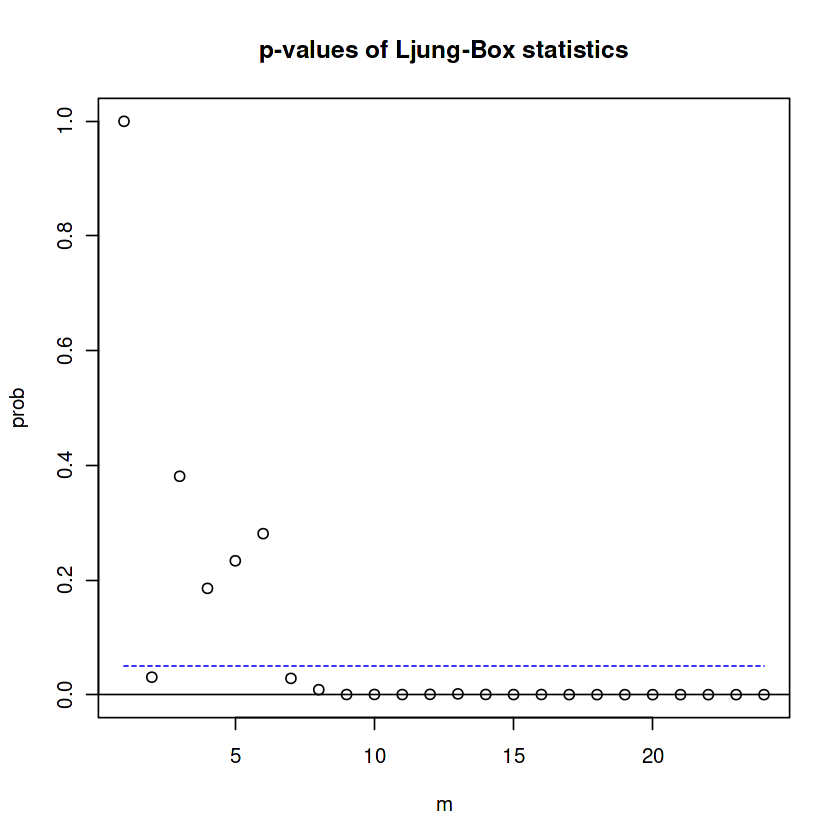

In [20]:
#Modelo check:
resi3=m3_mts$residuals
mq(resi3, adj=12) #Ajustamos los grados de libertad

Uno de los residuales esta por debajo del umbral por lo que el modelo. no se ajusta y debe Re plantearse el modelo

<a id="10"></a> <br>
## Portafolio diferenciado

Dado que se debe replantear el modelo se aplica la diferenciacion L1 para este nuevo modelo y se proceden a realizar nuevamentes las pruebas sobre las dos librerias VAR y MTS

### VAR con portafolio diferenciado:

In [21]:
#Comenzamos diferenciando los activos para luego, unirlos.
ryld.d=diff.xts(prices_train$RYLD)[-1,]
tsla.d=diff.xts(prices_train$TSLA)[-1,]
tm.d= diff.xts(prices_train$TM)[-1,]
gm.d= diff.xts(prices_train$GM)[-1,]
adf.test(ryld.d)
adf.test(tsla.d)
adf.test(tm.d)
adf.test(gm.d)


	Augmented Dickey-Fuller Test

data:  ryld.d
Dickey-Fuller = -7.8812, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tsla.d
Dickey-Fuller = -9.0446, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  tm.d
Dickey-Fuller = -10.59, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  gm.d
Dickey-Fuller = -9.7273, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


In [22]:
#Pasamos a formato ts
ryld.d.ts=ts(ryld.d, start= c(2019,01,01), frequency = 365)
tsla.d.ts= ts(tsla.d, start= c(2019,01,01), frequency = 365)
tm.d.ts=ts(tm.d, start= c(2019,01,01), frequency = 365)
gm.d.ts=ts(gm.d, start= c(2019,01,01), frequency = 365)

In [23]:
# Y unimos:
dataVAR3=ts.intersect(ryld.d.ts, tsla.d.ts, tm.d.ts, gm.d.ts) %>% na.omit()
head(dataVAR3)

ryld.d.ts,tsla.d.ts,tm.d.ts,gm.d.ts
0.16199875,0.07666588,0.7799988,0.3300018
0.03199959,-0.34933281,-2.0600052,-0.1100006
-0.05900002,-0.73533249,0.3100052,-0.6100006
0.09500122,-0.83266735,0.4300003,0.5699997
0.02499962,0.42199993,0.1899948,0.3299980
-0.03899956,-0.18533230,-0.2099991,-1.0599976


<a id="11"></a> <br>
### Nivel K Selection

In [24]:
#Nuevamente, seleccionamos nivel autorregresivo:
nivelk3=VARselect(dataVAR3, lag.max = 7, type = "const")
nivelk3$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

<a id="12"></a> <br>
### Johansen Test

In [25]:
#Podemos aplicar prueba Johansen test para verificar si hay estabilidad a largo plazo.
johatest=ca.jo(dataVAR3, type = "trace", K=2, ecdet ="none", spec = "longrun") #K is the number of lags to use in the vector autoregressive model and is set this to the minimum, K=2.
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.3567214 0.3396544 0.3166050 0.2624927

Values of teststatistic and critical values of test:

            test 10pct  5pct  1pct
r <= 3 |  268.86  6.50  8.18 11.65
r <= 2 |  605.00 15.66 17.95 23.52
r <= 1 |  971.44 28.71 31.52 37.22
r = 0  | 1361.00 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             ryld.d.ts.l2 tsla.d.ts.l2 tm.d.ts.l2  gm.d.ts.l2
ryld.d.ts.l2   1.00000000     1.000000  1.0000000  1.00000000
tsla.d.ts.l2  -0.03204476     1.879683 -0.1003516 -0.00348410
tm.d.ts.l2     0.08215704    -1.851224 -1.4732331 -0.02554770
gm.d.ts.l2    -0.60291677    -8.109574  0.9661581 -0.04329491

Weights W:
(This is the loading matrix)

            ryld.d.ts.l2  tsla.d.ts.l2 tm.d.ts.l2 gm.d.ts.l2
ryld.d.ts.d    0.1145006  0.0003723644 0.02450919 -0.9942444
tsla.d.ts.d    7.830915

<a id="13"></a> <br>
### VAR

In [26]:
#Armamos modelo VAR
var_est3 <- vars::VAR(y=dataVAR3, p=2)
summary(var_est3)


VAR Estimation Results:
Endogenous variables: ryld.d.ts, tsla.d.ts, tm.d.ts, gm.d.ts 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = dataVAR3, p = 2)


Estimation results for equation ryld.d.ts: 
ryld.d.ts = ryld.d.ts.l1 + tsla.d.ts.l1 + tm.d.ts.l1 + gm.d.ts.l1 + ryld.d.ts.l2 + tsla.d.ts.l2 + tm.d.ts.l2 + gm.d.ts.l2 + const 

               Estimate Std. Error t value Pr(>|t|)    
ryld.d.ts.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
tsla.d.ts.l1  0.0003732  0.0011952   0.312  0.75490    
tm.d.ts.l1   -0.0017988  0.0046631  -0.386  0.69977    
gm.d.ts.l1    0.0152832  0.0104306   1.465  0.14322    
ryld.d.ts.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
tsla.d.ts.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
tm.d.ts.l2   -0.0001906  0.0046566  -0.041  0.96736    
gm.d.ts.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const        -0.0054

<a id="13"></a> <br>
### MTS

In [27]:
m2_mts=MTS::VAR(dataVAR3, 2)

str(m2_mts)

Constant term: 
Estimates:  -0.005413425 0.2545003 0.007388606 -0.001985235 
Std.Error:  0.008886438 0.2742414 0.07765216 0.03683012 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]    [,3]     [,4]
[1,] -0.1405  0.000373 -0.0018  0.01528
[2,]  1.2525 -0.043873 -0.0131 -0.35200
[3,] -1.0907  0.014009  0.0122  0.09280
[4,] -0.0555  0.009925 -0.0102 -0.00975
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0427 0.00120 0.00466 0.0104
[2,] 1.3184 0.03688 0.14391 0.3219
[3,] 0.3733 0.01044 0.04075 0.0911
[4,] 0.1771 0.00495 0.01933 0.0432
AR( 2 )-matrix 
      [,1]     [,2]      [,3]    [,4]
[1,] 0.286 -0.00234 -0.000191 -0.0206
[2,] 2.394 -0.01228 -0.016173 -0.0696
[3,] 0.243 -0.00693  0.012395  0.1269
[4,] 0.442 -0.00867 -0.032857 -0.0179
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00466 0.0104
[2,] 1.3230 0.03689 0.14371 0.3213
[3,] 0.3746 0.01045 0.04069 0.0910
[4,] 0.1777 0.00495 0.01930 0.0431
  
Residuals cov-mtx: 
           [,1] 

In [28]:
phi1=m2_mts$Phi[,c(1,2,3,4)]
phi2=m2_mts$Phi[,c(5,6,7,8)]

phi1
phi2


eigen(phi1)
eigen(phi2)

-0.1404907,0.0003732345,-0.00179880,0.015283163
1.2525200,-0.0438732655,-0.01308319,-0.351999823
-1.0906540,0.0140094712,0.01220346,0.092795412
-0.0555048,0.0099249692,-0.01022899,-0.009745621


0.2856285,-0.002337941,-0.0001905935,-0.02061174
2.3936355,-0.012275556,-0.0161727385,-0.06961616
0.2429462,-0.006929522,0.0123948971,0.12692374
0.4421060,-0.008667257,-0.0328572185,-0.01792375


eigen() decomposition
$values
[1] -0.13131289+0.0000000i -0.03908925+0.0512035i -0.03908925-0.0512035i
[4]  0.02758529+0.0000000i

$vectors
               [,1]                    [,2]                    [,3]
[1,]  0.09942436+0i -0.01074075-0.02049658i -0.01074075+0.02049658i
[2,] -0.67072918+0i  0.93462308+0.00000000i  0.93462308+0.00000000i
[3,]  0.71726884+0i -0.16468012-0.23834030i -0.16468012+0.23834030i
[4,]  0.16050726+0i -0.04480032-0.20002879i -0.04480032+0.20002879i
               [,4]
[1,]  0.02517569+0i
[2,] -0.21483623+0i
[3,] -0.96159864+0i
[4,]  0.16893678+0i


eigen() decomposition
$values
[1] 0.238821635+0.00000000i 0.007484499+0.07601142i 0.007484499-0.07601142i
[4] 0.014033430+0.00000000i

$vectors
              [,1]                     [,2]                     [,3]
[1,] -0.1069278+0i  0.002971995-0.02991338i  0.002971995+0.02991338i
[2,] -0.9727854+0i -0.503574448-0.37591664i -0.503574448+0.37591664i
[3,] -0.1583986+0i -0.682478528+0.00000000i -0.682478528+0.00000000i
[4,] -0.1310150+0i -0.006778275-0.37198511i -0.006778275+0.37198511i
               [,4]
[1,] -0.01079383+0i
[2,] -0.98870521+0i
[3,]  0.14614217+0i
[4,] -0.03143207+0i


In [29]:
m3_mts=refVAR(m2_mts,thres = 1.96)

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,] -0.712    0    0    0
[4,]  0.000    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.2832    0    0    0
[4,] 0.0000    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000  0.0000 -0.0243
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.000  0.00000  0.0000  0.1554
[4,] 0.439 -0.00962 -0.0361  0.0000
standard error 
       [,1]   [,2]   [,3]    [,4]
[1,] 0.0396 0.0000 0.0000 0.00979
[2,] 0.0000 0.0000 0.0000 0.00000
[3,] 0.0000 0.0000 0.0000 0.07076
[4,] 0.1612 0.0049 0.0183 0.00000
  
Residuals cov-mtx: 
                      resi                    
     0.06916046  0.7964633 0.2955452 0.1612436
resi 0.79646333 65.9615077 4.8661707 2.6771854
     0.29554517  4.8661707 5.2722566 1.2711235
     0.16124361  2.67718

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      17.8     8.0     1.00
 [2,]   2.0      29.5    24.0     0.20
 [3,]   3.0      35.0    40.0     0.70
 [4,]   4.0      61.1    56.0     0.30
 [5,]   5.0      76.7    72.0     0.33
 [6,]   6.0      92.3    88.0     0.36
 [7,]   7.0     127.5   104.0     0.06
 [8,]   8.0     157.3   120.0     0.01
 [9,]   9.0     199.8   136.0     0.00
[10,]  10.0     216.8   152.0     0.00
[11,]  11.0     236.4   168.0     0.00
[12,]  12.0     248.0   184.0     0.00
[13,]  13.0     260.6   200.0     0.00
[14,]  14.0     284.8   216.0     0.00
[15,]  15.0     309.6   232.0     0.00
[16,]  16.0     327.2   248.0     0.00
[17,]  17.0     352.2   264.0     0.00
[18,]  18.0     373.5   280.0     0.00
[19,]  19.0     417.2   296.0     0.00
[20,]  20.0     425.9   312.0     0.00
[21,]  21.0     439.9   328.0     0.00
[22,]  22.0     452.4   344.0     0.00
[23,]  23.0     472.4   360.0     0.00
[24,]  24.0     507.7   376.0     0.00


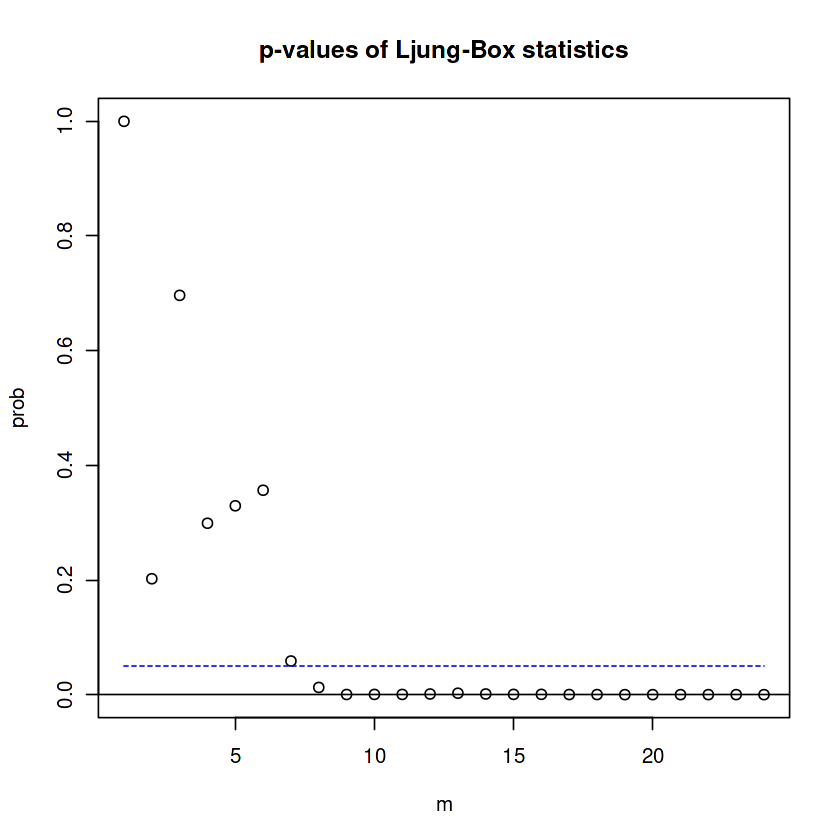

In [30]:
resi3=m3_mts$residuals
mq(resi3, adj=8) #Ajustamos los grados de libertad

In [31]:
dataVAR3_f=predict(var_est3, n.ahead=47)

<a id="14"></a> <br>
# Predicciones
<a id="14"></a> <br>
## Recover level forecast

In [32]:
#Como diferenciamos, recuperamos el nivel.
nhor=47 #pasos en el pronóstico.
nr_lev <- nrow(prices)
mr_lev= as.matrix(prices)
str(mr_lev)
m.varf_lev_ft <- rbind(mr_lev, matrix(NA, nhor,4 ))
m.ft_df <- do.call(cbind,lapply(dataVAR3_f$fcst, 
                                function(x) x[,"fcst"]))


 num [1:933, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:933] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


<a id="15"></a> <br>
### Growth to level

In [33]:
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

<a id="16"></a> <br>
### Draw Graph

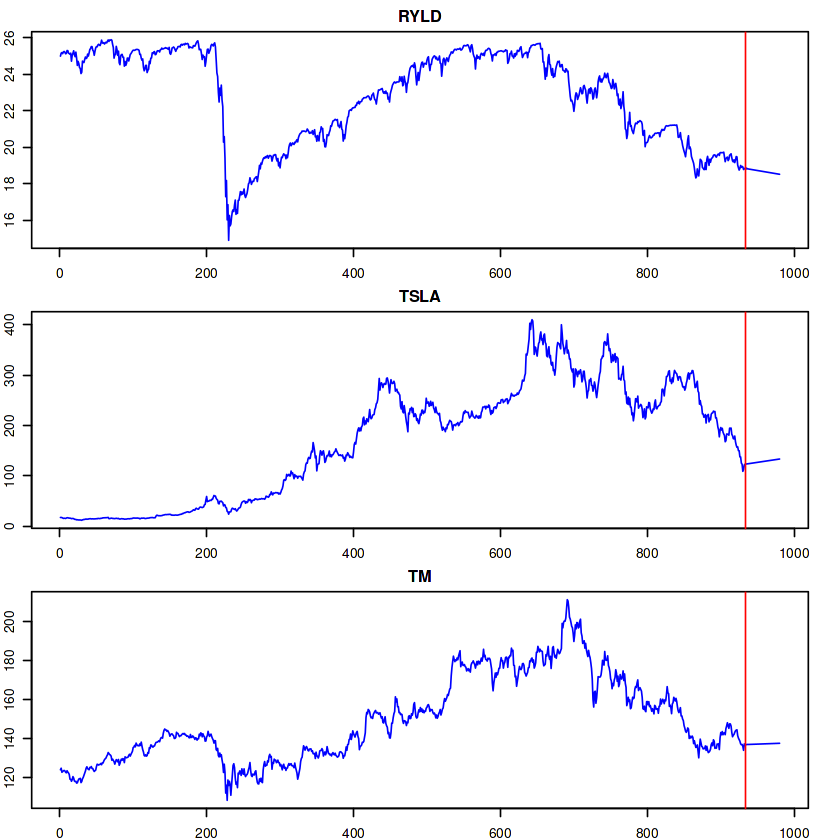

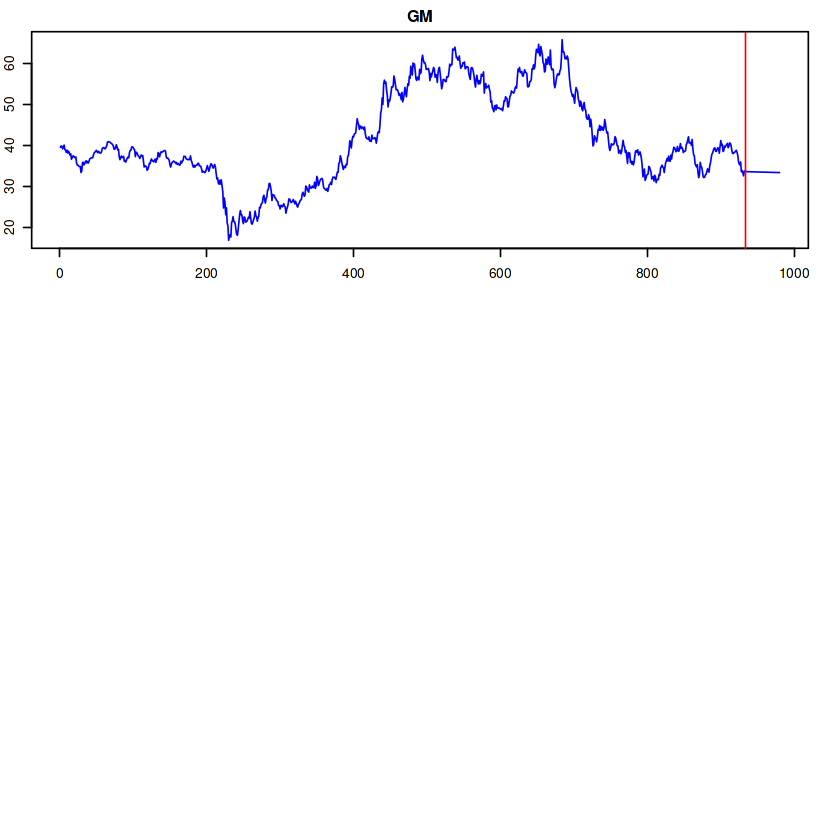

In [34]:
str.main=c("RYLD", "TSLA", "TM", "GM")
par(mfrow=c(3,1), mar=c(2,2,2,2))

for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="red")
}

In [41]:
###Cálculo error MAPE, RMSE
library(Metrics)

y_pred = m.varf_lev_ft[(nrow(m.varf_lev_ft) - nhor + 1):nrow(m.varf_lev_ft), "RYLD"]
y_test = prices_test$RYLD

MSE1<-mse(y_test,y_pred)
MSE1
RMSE1<-rmse(y_test,y_pred)
RMSE1
MAPE1<-mape(y_test, y_pred)
MAPE1
MAE1<-mae(y_test,y_pred)
MAE1

[1] 0.4965795

[1] 0.704684

[1] 0.03425764

[1] 0.6658837

<a id="17"></a> <br>
### Función de Impulso Respuesta

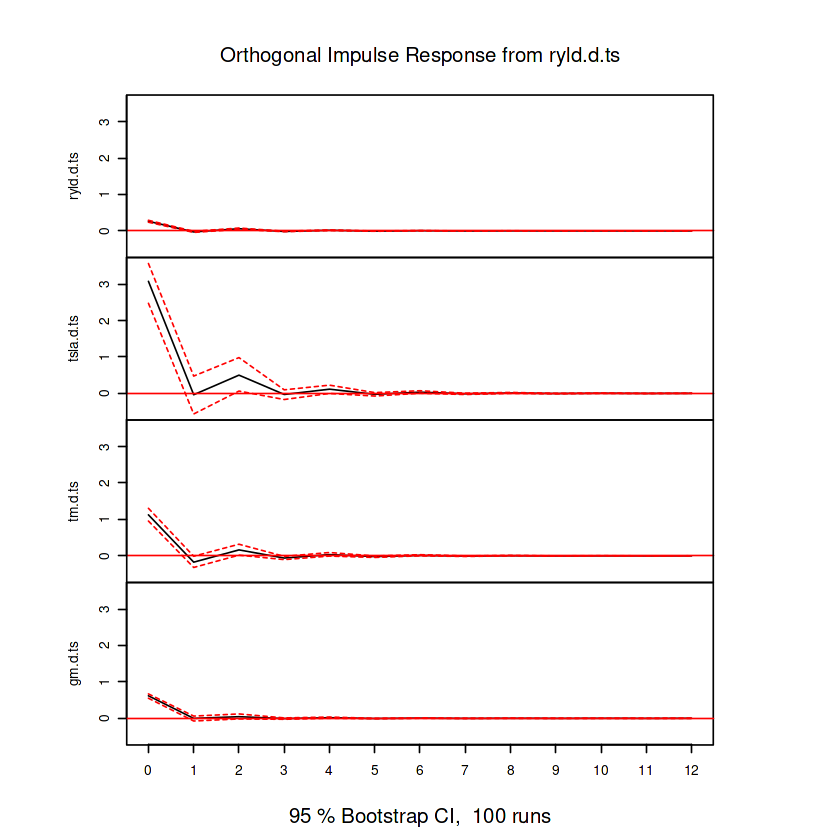

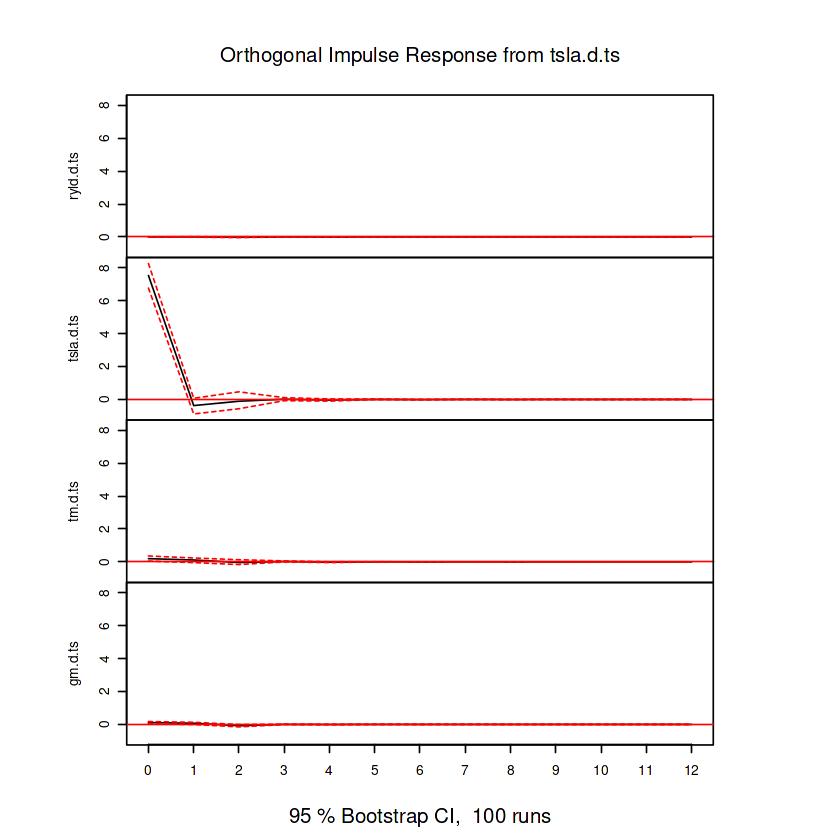

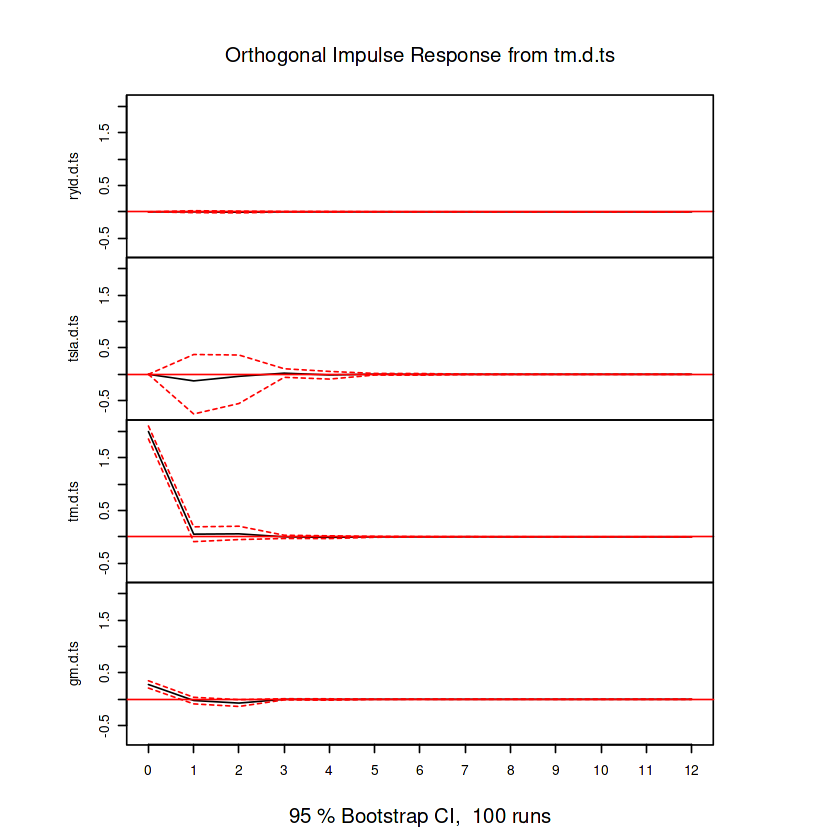

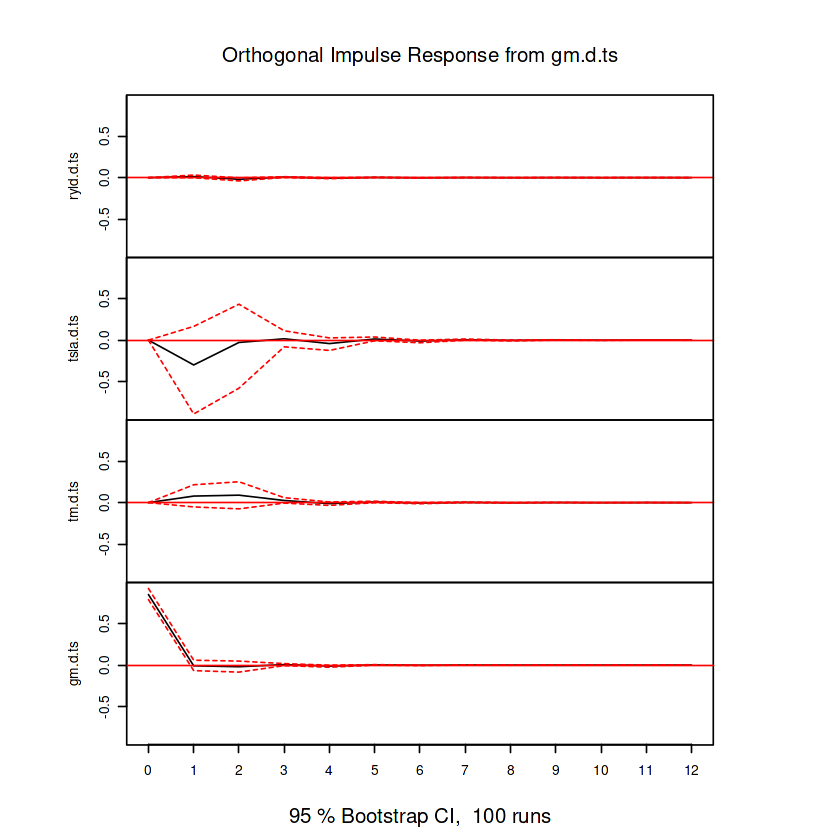

In [36]:
# Aplicamos la función irf al modelo VAR, de la paquetería vars donde los datos eran estacionarios.
m1irf = irf(var_est3, n.ahead = 12, boot = TRUE)
plot(m1irf) 